## CPE311 Computational Thinking with Python

## Hands-on Activity 8.1: Aggregating Data with Pandas

Name: Bulambao, Adrian Justin

Section: CPE22S3

Performed on: 04/12/2025

Submitted on: 04/12/2025

Submitted to: Engr. Roman M. Richard

### 8.1.1 Intended Learning Outcomes

• Demonstrate querying and merging of dataframes

• Perform advanced calculations on dataframes

• Aggregate dataframes with pandas and numpy

• Work with time series data


## 8.1.2 Resources

• Computing Environment using Python 3.x

• Attached Datasets (under Instructional Materials)

## 8.1.3 Procedures

The procedures can be found in the canvas module. Check the following under topics:

• 8.1 Weather Data Collection

• 8.2 Querying and Merging

• 8.3 Dataframe Operations

• 8.4 Aggregations

•8.5 Time Series

# 8.1 Weather Data Collection

## Collecting weather data from an API

## About the data


In this notebook, we will be collecting daily weather data from the National Centers for Environmental Information (NCEI) API. We will use the Global Historical Climatology
Network - Daily (GHCND) data set; see the documentation here.
    
Note: The NCEI is part of the National Oceanic and Atmospheric Administration (NOAA) and, as you can see from the URL for the API, this resource was created when the
NCEI was called the NCDC. Should the URL for this resource change in the future, you can search for the NCEI weather API to find the updated one.

### Using the NCEI API

Paste your token below.

In [23]:
import requests
def make_request(endpoint, payload=None):
     """
     Make a request to a specific endpoint on the weather API
     passing headers and optional payload.
    
     Parameters:
     - endpoint: The endpoint of the API you want to
     make a GET request to.
     - payload: A dictionary of data to pass along
     with the request.
    
     Returns:
     Response object.
     """
     return requests.get(f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',headers={'token': 'FqULZglLVhoNKxDtgXTYDVDcgBzgnpGb'},
         params=payload)
params = {
    'datasetid': 'GHCND',
    'locationid': 'ZIP:28428',        # North Carolina, for example
    'startdate': '2023-01-01',
    'enddate': '2023-01-03',
    'limit': 3
}
response = make_request('data',params)
print(response.json())

{'metadata': {'resultset': {'offset': 1, 'count': 5, 'limit': 3}}, 'results': [{'date': '2023-01-01T00:00:00', 'datatype': 'PRCP', 'station': 'GHCND:US1NCNH0062', 'attributes': ',,N,0700', 'value': 5}, {'date': '2023-01-02T00:00:00', 'datatype': 'PRCP', 'station': 'GHCND:US1NCNH0062', 'attributes': ',,N,0700', 'value': 0}, {'date': '2023-01-02T00:00:00', 'datatype': 'SNOW', 'station': 'GHCND:US1NCNH0062', 'attributes': ',,N,0700', 'value': 0}]}


In [28]:
import pandas as pd
# Get JSON from the response
data = response.json()

# Convert just the 'results' list to a DataFrame
df = pd.DataFrame(data['results'])

df

,date,datatype,station,attributes,value
0,2023-01-01T00:00:00,PRCP,GHCND:US1NCNH0062,",,N,0700",5
1,2023-01-02T00:00:00,PRCP,GHCND:US1NCNH0062,",,N,0700",0
2,2023-01-02T00:00:00,SNOW,GHCND:US1NCNH0062,",,N,0700",0


## Collect All Data Points for 2018 In NYC (Various Stations)

We can make a loop to query for all the data points one day at a time. Here we create a list of all the results:

In [30]:
import datetime
from IPython import display # for updating the cell dynamically
current = datetime.date(2018, 1, 1)
end = datetime.date(2019, 1, 1)
results = []
while current < end:
     # update the cell with status information
     display.clear_output(wait=True)
     display.display(f'Gathering data for {str(current)}')
    
     response = make_request(
         'data',
         {
             'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
             'locationid' : 'CITY:US360019', # NYC
             'startdate' : current,
             'enddate' : current,
             'units' : 'metric',
             'limit' : 1000 # max allowed
             #was set to 10 to avoid long time of gathering data
         }
     )
     if response.ok:
         # we extend the list instead of appending to avoid getting a nested list
         results.extend(response.json()['results'])
     # update the current date to avoid an infinite loop
     current += datetime.timedelta(days=1)

'Gathering data for 2018-12-31'

Now, we can create a dataframe with all this data. Notice there are multiple stations with values for each datatype on a given day. We don't know what the stations are, but we
can look them up and add them to the data:


In [31]:
df = pd.DataFrame(results)
df.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


Save this data to a file:

In [32]:
df.to_csv('nyc_weather_2018.csv', index=False)

and write it to the database:

In [33]:
import sqlite3
with sqlite3.connect('weather.db') as connection:
    df.to_sql(
        'weather', connection, index=False, if_exists='replace'
)

For learning about merging dataframes, we will also get the data mapping station IDs to information about the station:

In [35]:
response = make_request(
    'stations',
    {
        'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
        'locationid' : 'CITY:US360019', # NYC
        'limit' : 1000 # max allowed
    }
)
stations = pd.DataFrame(response.json()['results'])[['id', 'name', 'latitude', 'longitude', 'elevation']]
stations.to_csv('weather_stations.csv', index=False)
with sqlite3.connect('weather.db') as connection:
    stations.to_sql(
        'stations', connection, index=False, if_exists='replace'
 )

## Database-style Operations on Dataframes


### About the data

In this notebook, we will using daily weather data that was taken from the National Centers for Environmental Information (NCEI) API. The data collection notebook contains the process that was followed to collect the data.

Note: The NCEI is part of the National Oceanic and Atmospheric Administration (NOAA) and, as you can see from the URL for the API, this resource was created when the NCEI was called the NCDC. Should the URL for this resource change in the future, you can search for the CEI weather API to find the updated one.

### Background on the data
Data meanings:
    PRCP : precipitation in millimeters
    SNOW : snowfall in millimeters
    SNWD : snow depth in millimeters
    TMAX : maximum daily temperature in Celsius
    TMIN : minimum daily temperature in Celsius
    TOBS : temperature at time of observation in Celsius
    WESF : water equivalent of snow in millimeters
### Setup

In [48]:
import pandas as pd # this is the library to read, create dataframes
weather = pd.read_csv('nyc_weather_2018.csv')
#pd.read_csv is a command to read a csv
weather.head() 
#head() is a command to display the first 5 rows

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


### Querying DataFrames

The query() method is an easier way of filtering based on some criteria. For example, we can use it to find all entries where snow was recorded:

In [49]:
snow_data = weather.query('datatype == "SNOW" and value > 0')
#query is a command use to filter the dataframe with user
# made filters
snow_data.head()

,date,datatype,station,attributes,value
127,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
816,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1600",229.0
819,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0830",10.0
823,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0018,",,N,0910",46.0
830,2018-01-04T00:00:00,SNOW,GHCND:US1NJES0018,",,N,0700",10.0


This is equivalent to quering the data/weather.db SQLite database for SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0 :

In [50]:
import sqlite3
#sqlite3 is a library for sql modifications


with sqlite3.connect('weather.db') as connection:
    snow_data_from_db = pd.read_sql(
        'SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0',
        connection
 )
snow_data.reset_index().drop(columns='index').equals(snow_data_from_db)

True

Note this is also equivalent to creating Boolean masks:

In [59]:
weather[(weather.datatype == 'SNOW') & (weather.value > 0)].equals(snow_data)
# this checks if the snow datatype == "SNOW" and value > 0
# is equal to snow_data

True

# Merging DataFrames
We have data for many different stations each day; however, we don't know what the stations are just their IDs. We can join the data in the data/weather_stations.csv file which contains information from the stations endpoint of the NCEI API. Consult the weather_data_collection.ipynb notebook to see how this was collected. It looks like this:

In [60]:
station_info = pd.read_csv('weather_stations.csv')
#pd.read_csv reads the csv to a dataframe
station_info.head()
#.head() displays the first 5 rows
# of a dataframe

,id,name,latitude,longitude,elevation
0,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,-73.577000,36.6
1,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
2,GHCND:US1NJBG0001,"BERGENFIELD 0.3 SW, NJ US",40.921298,-74.001983,20.1
3,GHCND:US1NJBG0002,"SADDLE BROOK TWP 0.6 E, NJ US",40.902694,-74.083358,16.8
4,GHCND:US1NJBG0003,"TENAFLY 1.3 W, NJ US",40.914670,-73.977500,21.6


As a reminder, the weather data looks like this:

In [61]:
weather.head()
# displays the first 5 rows
# of the weather data

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


We can join our data by matching up the station_info.id column with the weather.station column. Before doing that though, let's see how many unique values we have:

In [62]:
station_info.id.describe()
#describes does what it is called
# it describes the the id of the dataframe

count                   330
unique                  330
top       GHCND:USW00094789
freq                      1
Name: id, dtype: object

While station_info has one row per station, the weather dataframe has many entries per station. Notice it also has fewer uniques:

In [64]:
weather.station.describe()
# this describes the station column

count                 89114
unique                  114
top       GHCND:USW00014734
freq                   6593
Name: station, dtype: object

When working with joins, it is important to keep an eye on the row count. Some join types will lead to data loss:

In [66]:
station_info.shape[0], weather.shape[0]
# the shape commands takes the row and columns of the data frame
#[0] is the first in those data

(330, 89114)

Since we will be doing this often, it makes more sense to write a function:

In [68]:
def get_row_count(*dfs):
    return [df.shape[0] for df in dfs]
get_row_count(station_info, weather)
# this is a function for the code above
# it loops the given data and takes the shape
# for each

[330, 89114]

The map() function is more efficient than list comprehensions. We can couple this with getattr() to grab any attribute for multiple dataframes:

In [71]:
def get_info(attr, *dfs):
    return list(map(lambda x: getattr(x, attr), dfs))
get_info('shape', station_info, weather)


[(330, 5), (89114, 5)]

By default merge() performs an inner join. We simply specify the columns to use for the join. The left dataframe is the one we call merge() on, and the right one is passed in as an argument:


In [77]:
inner_join = weather.merge(station_info, left_on='station', right_on='id')
inner_join.sample(5, random_state=0)
#this inner joins the weather dataframe and the station dataframe
#joining them by id and station
# then takes a sample

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
464,2018-01-02T00:00:00,TMIN,GHCND:USW00014734,",,W,2400",-11.0,GHCND:USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",40.68275,-74.169270,1.9
44013,2018-06-29T00:00:00,WDF5,GHCND:USW00054743,",,W,",300.0,GHCND:USW00054743,"CALDWELL ESSEX CO AIRPORT, NJ US",40.87645,-74.282840,52.0
2079,2018-01-08T00:00:00,PRCP,GHCND:USC00308577,",,7,0800",0.0,GHCND:USC00308577,"SYOSSET, NY US",40.82160,-73.490800,80.8
12170,2018-02-19T00:00:00,WESD,GHCND:US1NJMD0062,"T,,N,0700",0.0,GHCND:US1NJMD0062,"OLD BRIDGE TWP 5.1 NE, NJ US",40.45623,-74.241325,7.6
73861,2018-10-30T00:00:00,RHAV,GHCND:USW00094728,",,W,",52.0,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.969250,42.7


We can remove the duplication of information in the station and id columns by renaming one of them before the merge and then simply using on :

In [79]:
weather.merge(station_info.rename(dict(id='station'), axis=1), on='station').sample(5, random_state=0)
# this merges the weather and the station info, then ranames the id column to station
# then merges the two station named columns

,date,datatype,station,attributes,value,name,latitude,longitude,elevation
464,2018-01-02T00:00:00,TMIN,GHCND:USW00014734,",,W,2400",-11.0,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",40.68275,-74.169270,1.9
44013,2018-06-29T00:00:00,WDF5,GHCND:USW00054743,",,W,",300.0,"CALDWELL ESSEX CO AIRPORT, NJ US",40.87645,-74.282840,52.0
2079,2018-01-08T00:00:00,PRCP,GHCND:USC00308577,",,7,0800",0.0,"SYOSSET, NY US",40.82160,-73.490800,80.8
12170,2018-02-19T00:00:00,WESD,GHCND:US1NJMD0062,"T,,N,0700",0.0,"OLD BRIDGE TWP 5.1 NE, NJ US",40.45623,-74.241325,7.6
73861,2018-10-30T00:00:00,RHAV,GHCND:USW00094728,",,W,",52.0,"NY CITY CENTRAL PARK, NY US",40.77898,-73.969250,42.7


We are losing stations that don't have weather observations associated with them, if we don't want to lose these rows, we perform a right or left join instead of the inner join:


In [82]:
left_join = station_info.merge(weather, left_on='id', right_on='station', how='left')
# this joins the station_info dataframe and the weather dataframe 
# with the id and station column respectively
#and left joins it 
right_join = weather.merge(station_info, left_on='station', right_on='id', how='right')
# this joins the weather dataframe and the data_info dataframe 
# with the station and id column respectively
#and right joins it 
right_join.tail()

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
89325,2018-12-31T00:00:00,WDF5,GHCND:USW00094789,",,W,",130.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
89326,2018-12-31T00:00:00,WSF2,GHCND:USW00094789,",,W,",9.8,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
89327,2018-12-31T00:00:00,WSF5,GHCND:USW00094789,",,W,",12.5,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
89328,2018-12-31T00:00:00,WT01,GHCND:USW00094789,",,W,",1.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
89329,2018-12-31T00:00:00,WT02,GHCND:USW00094789,",,W,",1.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7


The left and right join as we performed above are equivalent because the side that we kept the rows without matches was the same in both cases:


In [85]:
left_join.sort_index(axis=1).sort_values(['date', 'station']).reset_index().drop(columns='index').equals(
 right_join.sort_index(axis=1).sort_values(['date', 'station']).reset_index().drop(columns='index')
)

#this checks if the sorted column of the sorted values of data and station
# columns and resetted index of the left_join dataframe created
#in the previous cell is equal to the sorted column of the the sorted values of data and station
# columns and resetted index of the right_join dataframe created in the previous cell

True

Note we have additional rows in the left and right joins because we kept all the stations that didn't have weather observations:


In [87]:
get_info('shape', inner_join, left_join, right_join)
# this takes the number of rows and columns 
#of inner_join, left_join, right_join
#dataframes
# as seen below all left and right join are only equal

[(89114, 10), (89330, 10), (89330, 10)]

If we query the station information for stations that have NY in their name, believing that to be all the stations that record weather data for NYC and perform an outer join, we can see where the mismatches occur:

In [100]:
outer_join = weather.merge(
    station_info[station_info.name.str.contains('NY')],
    left_on='station', right_on='id', how='outer', indicator=True)

outer_join.sample(4, random_state=0).append(outer_join[outer_join.station.isna()].head(2))

#ayaw na po gumana

AttributeError: 'DataFrame' object has no attribute 'append'

These joins are equivalent to their SQL counterparts. Below is the inner join. Note that to use equals() you will have to do some manipulation of the dataframes to line them up:

In [101]:
import sqlite3
with sqlite3.connect('weather.db') as connection:
    inner_join_from_db = pd.read_sql(
        'SELECT * FROM weather JOIN stations ON weather.station == stations.id',
        connection
 )
inner_join_from_db.shape == inner_join.shape

# sorry sir di ko na malagyan
# ng comments
# less than 1 hour na lang po meron ako
# sinusubukan ko naman po na intindihin yung mga
# ni copy paste ko

True

Revisit the dirty data from the previous module.

In [102]:
dirty_data = pd.read_csv('dirty_data.csv', index_col='date').drop_duplicates().drop(columns='SNWD')
dirty_data.head()

,station,PRCP,SNOW,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,
2018-01-01T00:00:00,?,0.0,0.0,5505.0,-40.0,NaN,NaN,NaN
2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-8.3,-16.1,-12.2,NaN,False
2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-4.4,-13.9,-13.3,NaN,False
2018-01-04T00:00:00,?,20.6,229.0,5505.0,-40.0,NaN,19.3,True
2018-01-05T00:00:00,?,0.3,NaN,5505.0,-40.0,NaN,NaN,NaN


We need to create two dataframes for the join. We will drop some unecessary columns as well for easier viewing:

In [103]:
valid_station = dirty_data.query('station != "?"').copy().drop(columns=['WESF', 'station'])
station_with_wesf = dirty_data.query('station == "?"').copy().drop(columns=['station', 'TOBS', 'TMIN', 'TMAX'])

In [104]:
valid_station.merge(
    station_with_wesf, left_index=True, right_index=True
).query('WESF > 0').head()

,PRCP_x,SNOW_x,TMAX,TMIN,TOBS,inclement_weather_x,PRCP_y,SNOW_y,WESF,inclement_weather_y
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


The columns that existed in both dataframes, but didn't form part of the join got suffixes added to their names: _x for columns from the left dataframe and _y for columns from the right dataframe. We can customize this with the suffixes argument:


In [105]:
valid_station.merge(station_with_wesf, left_index=True, right_index=True, suffixes=('', '_?')
).query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


Since we are joining on the index, an easier way is to use the join() method instead of merge() . Note that the suffix parameter is now lsuffix for the left dataframe's suffix and rsuffix for the right one's:

In [106]:
valid_station.join(station_with_wesf, rsuffix='_?').query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


Joins can be very resource-intensive, so it's a good idea to figure out what type of join you need using set operations before trying the join itself. The pandas set operations are performed on the index, so whichever columns we will be joining on will need to be the index. Let's go back to the weather and station_info dataframes and set the station ID columns as the index:

In [107]:
weather.set_index('station', inplace=True)
station_info.set_index('id', inplace=True)

In [108]:
weather.index.intersection(station_info.index)

Index(['GHCND:US1CTFR0039', 'GHCND:US1NJBG0015', 'GHCND:US1NJBG0017',
       'GHCND:US1NJBG0018', 'GHCND:US1NJBG0023', 'GHCND:US1NJBG0030',
       'GHCND:US1NJBG0039', 'GHCND:US1NJBG0044', 'GHCND:US1NJES0018',
       'GHCND:US1NJES0024',
       ...
       'GHCND:USC00284987', 'GHCND:US1NJES0031', 'GHCND:US1NJES0029',
       'GHCND:US1NJMD0086', 'GHCND:US1NJMS0097', 'GHCND:US1NJMN0081',
       'GHCND:US1NJMD0088', 'GHCND:US1NJES0033', 'GHCND:US1NJES0040',
       'GHCND:US1NYQN0029'],
      dtype='object', length=114)

The set difference will tell us what we lose from each side. When performing an inner join, we lose nothing from the weather dataframe:

In [109]:
weather.index.difference(station_info.index)

Index([], dtype='object')

We lose 153 stations from the station_info dataframe, however:

In [110]:
station_info.index.difference(weather.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1NJBG0001', 'GHCND:US1NJBG0002',
       'GHCND:US1NJBG0005', 'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008',
       'GHCND:US1NJBG0011', 'GHCND:US1NJBG0012', 'GHCND:US1NJBG0013',
       'GHCND:US1NJBG0020',
       ...
       'GHCND:USC00308749', 'GHCND:USC00308946', 'GHCND:USC00309117',
       'GHCND:USC00309270', 'GHCND:USC00309400', 'GHCND:USC00309466',
       'GHCND:USC00309576', 'GHCND:USC00309580', 'GHCND:USW00014708',
       'GHCND:USW00014786'],
      dtype='object', length=216)

The symmetric difference will tell us what gets lost from both sides. It is the combination of the set difference in both directions:


In [111]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).shape[0]\
+ weather.index.difference(ny_in_name.index).shape[0]\
== weather.index.symmetric_difference(ny_in_name.index).shape[0]

True

The union will show us everything that will be present after a full outer join. Note that since these are sets (which don't allow duplicates by definition), we must pass unique entries for union:

In [112]:
weather.index.unique().union(station_info.index)


Index(['GHCND:US1CTFR0022', 'GHCND:US1CTFR0039', 'GHCND:US1NJBG0001',
       'GHCND:US1NJBG0002', 'GHCND:US1NJBG0003', 'GHCND:US1NJBG0005',
       'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008', 'GHCND:US1NJBG0010',
       'GHCND:US1NJBG0011',
       ...
       'GHCND:USW00014708', 'GHCND:USW00014732', 'GHCND:USW00014734',
       'GHCND:USW00014786', 'GHCND:USW00054743', 'GHCND:USW00054787',
       'GHCND:USW00094728', 'GHCND:USW00094741', 'GHCND:USW00094745',
       'GHCND:USW00094789'],
      dtype='object', length=330)

Note that the symmetric difference is actually the union of the set differences:

In [113]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).union(weather.index.difference(ny_in_name.index)).equals(
 weather.index.symmetric_difference(ny_in_name.index)
)

True

## DataFrame Operation

## About the Data

In this notebook, we will be working with 2 data sets:

Facebook's stock price throughout 2018 (obtained using the stock_analysis package).

daily weather data for NYC from the National Centers for Environmental Information (NCEI) API.
                                                    
Note: The NCEI is part of the National Oceanic and Atmospheric Administration (NOAA) and, as you can see from the URL for the API, this resource was created when the
NCEI was called the NCDC. Should the URL for this resource change in the future, you can search for the NCEI weather API to find the updated one.

                                    
## Background on the weather data
                                    
Data meanings:
                                    
                                    
        AWND : average wind speed
        PRCP : precipitation in millimeters
        SNOW : snowfall in millimeters
        SNWD : snow depth in millimeters
        TMAX : maximum daily temperature in Celsius
        TMIN : minimum daily temperature in Celsius
## Setup

In [114]:
import numpy as np
import pandas as pd
weather = pd.read_csv('nyc_weather_2018.csv', parse_dates=['date'])
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [116]:
fb = pd.read_csv('fb_2018.csv', index_col='date', parse_dates=True)
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


## Arithmetic and statistics

We already saw that we can use mathematical operators like + and / with dataframes directly. However, we can also use methods, which allow us to specify the axis to perform the calculation over. By default this is per column. Let's find the z-scores for the volume traded and look at the days where this was more than 3 standard deviations from the mean:

In [117]:
fb.assign(
    abs_z_score_volume=lambda x: x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()
).query('abs_z_score_volume > 3')

,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


We can use rank() and pct_change() to see which days had the largest change in volume traded from the day before:

In [118]:
fb.assign(
 volume_pct_change=fb.volume.pct_change(),
 pct_change_rank=lambda x: x.volume_pct_change.abs().rank(
 ascending=False
 )
).nsmallest(5, 'pct_change_rank')


,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


January 12th was when the news that Facebook changed its news feed product to focus more on content from a users' friends over the brands they follow. Given that Facebook's advertising is a key component of its business (nearly 89% in 2017), many shares were sold and the price dropped in panic:


In [119]:
fb['2018-01-11':'2018-01-12']

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


Throughout 2018, Facebook's stock price never had a low above $215:

In [120]:
(fb > 215).any()

open       True
high       True
low       False
close      True
volume     True
dtype: bool

Facebook's OHLC (open, high, low, and close) prices all had at least one day they were at $215 or less:

In [121]:
(fb > 215).all()

open      False
high      False
low       False
close     False
volume     True
dtype: bool

## Binning and thresholds

When working with the volume traded, we may be interested in ranges of volume rather than the exact values. No two days have the same volume traded:

In [122]:
(fb.volume.value_counts() > 1).sum()

np.int64(0)

We can use pd.cut() to create 3 bins of even an even range in volume traded and name them. Then we can work with low, medium, and high volume traded categories:

In [123]:
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()

volume
low     240
med       8
high      3
Name: count, dtype: int64

In [125]:
fb[volume_binned == 'high'].sort_values('volume', ascending=False)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


July 25th Facebook announced disappointing user growth and the stock tanked in the after hours:

In [126]:
fb['2018-07-25':'2018-07-26']

,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


Cambridge Analytica scandal broke on Saturday March 17th, so we look to the Monday for the numbers:

In [127]:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


Since most days have similar volume, but a few are very large, we have very wide bins. Most of the data is in the low bin.

Note: visualizations will be covered in chapters 5 and 6

In [130]:
import matplotlib.pyplot as plt

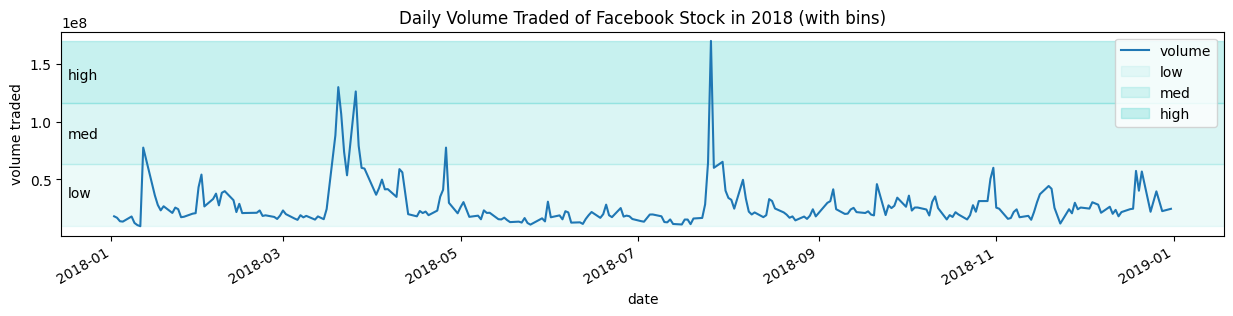

In [131]:
fb.plot(y='volume', figsize=(15, 3), title='Daily Volume Traded of Facebook Stock in 2018 (with bins)')
for bin_name, alpha, bounds in zip(
 ['low', 'med', 'high'], [0.1, 0.2, 0.3], pd.cut(fb.volume, bins=3).unique().categories.values
):
 plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
 plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()

If we split using quantiles, the bins will have roughly the same number of observations. For this, we use qcut() . We will make 4 quartiles:

In [132]:
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

volume
q1    63
q2    63
q4    63
q3    62
Name: count, dtype: int64

Notice the bins don't cover ranges of the same size anymore:

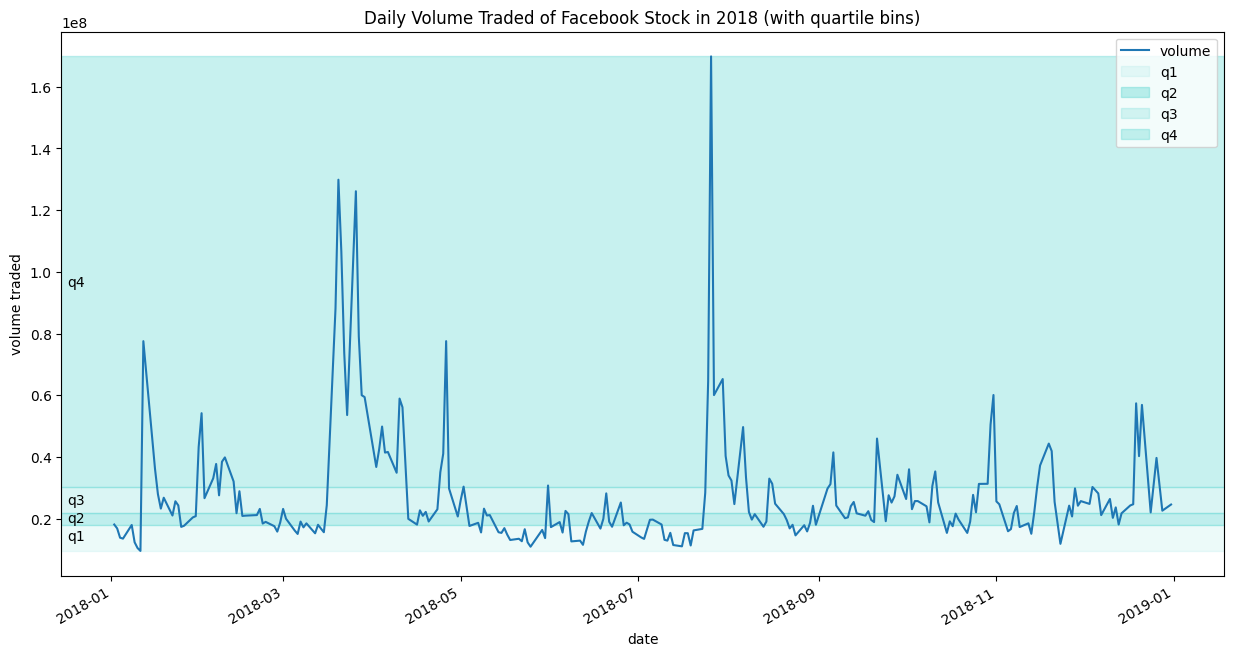

In [133]:
fb.plot(y='volume', figsize=(15, 8), title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)')
for bin_name, alpha, bounds in zip(
 ['q1', 'q2', 'q3', 'q4'], [0.1, 0.35, 0.2, 0.3], pd.qcut(fb.volume, q=4).unique().categories.values
):
 plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
 plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()

Sometimes we don't want to make bins, but rather cap values at a threshold. Before we look at an example, let's pivot our weather data for the Central Park station:

In [138]:
central_park_weather = weather.query(
 'station == "GHCND:USW00094728"'
).pivot(index='date', columns='datatype', values='value')

central_park_weather.head()

datatype,ADPT,ASLP,ASTP,AWBT,AWND,PRCP,RHAV,RHMN,RHMX,SNOW,...,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT06,WT08
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-194.0,10278.0,10224.0,-122.0,3.5,0.0,48.0,34.0,60.0,0.0,...,-13.8,300.0,300.0,6.7,11.2,NaN,NaN,NaN,NaN,NaN
2018-01-02,-156.0,10278.0,10227.0,-94.0,3.6,0.0,52.0,42.0,62.0,0.0,...,-10.5,260.0,250.0,7.2,12.5,NaN,NaN,NaN,NaN,NaN
2018-01-03,-161.0,10237.0,10196.0,-78.0,1.4,0.0,42.0,28.0,51.0,0.0,...,-8.8,260.0,270.0,6.3,9.8,NaN,NaN,NaN,NaN,NaN
2018-01-04,-94.0,9990.0,9925.0,-61.0,5.6,19.3,70.0,39.0,92.0,249.0,...,-7.1,310.0,310.0,10.7,19.2,1.0,1.0,NaN,NaN,1.0
2018-01-05,-206.0,10098.0,10030.0,-128.0,5.8,0.0,43.0,33.0,56.0,0.0,...,-12.7,280.0,280.0,9.4,15.7,NaN,NaN,NaN,NaN,NaN


Say we don't care how much snow their was, just that it snowed in Central Park. However, we don't want to make a Boolean column since we need to preserve the data type of float. We can use clip() to replace values above a upper threshold with the threshold and replace values below a lower threshold with the lower threshold. This means we can use clip(0, 1) to change all the snow values of one or more to 1, which easily shows us the days snow was recorded in Central Park. Preserving the data type will save some work later on if we are building a model:


In [139]:
central_park_weather.SNOW.clip(0, 1).value_counts()

SNOW
0.0    343
1.0     10
Name: count, dtype: int64

Note: the clip() method can also be called on the dataframe itself.

## Applying Functions

We can use the apply() method to run the same operation on all columns (or rows) of the dataframe. Let's calculate the z-scores of the TMIN, TMAX, and PRCP
observations in Central Park in October 2018:

In [140]:
oct_weather_z_scores = central_park_weather.loc[
 '2018-10', ['TMIN', 'TMAX', 'PRCP']
].apply(lambda x: x.sub(x.mean()).div(x.std()))
oct_weather_z_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
datatype,,,,,,,,
TMIN,30.0,1.110223e-16,1.0,-1.307499,-0.717650,-0.440074,1.056235,1.884625
TMAX,30.0,2.581269e-16,1.0,-1.276439,-0.863456,-0.151720,0.990573,1.658374
PRCP,30.0,4.070818e-17,1.0,-0.401814,-0.401814,-0.401814,-0.239899,3.867458


October 27th rained much more than the rest of the days:

In [141]:
oct_weather_z_scores.query('PRCP > 3')

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-27,-0.71765,-1.170996,3.867458


Indeed, this day was much higher than the rest:

In [142]:
central_park_weather.loc['2018-10', 'PRCP'].describe()

count    30.000000
mean      3.040000
std       7.565694
min       0.000000
25%       0.000000
50%       0.000000
75%       1.225000
max      32.300000
Name: PRCP, dtype: float64

When the function we want to apply isn't vectorized, we can:

        use np.vectorize() to vectorize it (similar to how map() works) and then use it with apply()
        use applymap() and pass it the non-vectorized function directly

Say we wanted to count the digits of the whole numbers for the Facebook data. len() is not vectorized:

In [145]:
import numpy as np
fb.apply(lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
).astype('int64').equals(fb.applymap(lambda x: len(str(np.ceil(x)))))

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\290225260.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ).astype('int64').equals(fb.applymap(lambda x: len(str(np.ceil(x)))))


True

A simple operation of addition to each element in a series grows linearly in time complexity when using iteritems() , but stays near 0 when using vectorized operations. iteritems() and related methods should only be used if there is no vectorized solution:

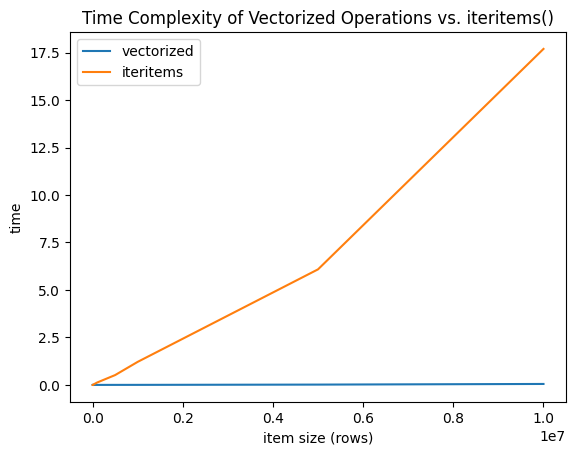

In [155]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(0)
vectorized_results = {}
iteritems_results = {}
for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
    test = pd.Series(np.random.uniform(size=size))
    
    start = time.time()
    x = test + 10
    end = time.time()
    vectorized_results[size] = end - start
    
    start = time.time()
    x = []
    for i, v in test.items():  # <--- fixed line
        x.append(v + 10)
    x = pd.Series(x)
    end = time.time()
    iteritems_results[size] = end - start


pd.DataFrame( [pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
).T.plot(title='Time Complexity of Vectorized Operations vs. iteritems()')
plt.xlabel('item size (rows)')
plt.ylabel('time')
plt.show()

### Window Calculations

Consult the understanding windows calculation notebook for interactive visualizations to help understand window calculations.
The rolling() method allows us to perform rolling window calculations. We simply specify the window size (3 days here) and follow it with a call to an aggregation
function (sum here):

In [159]:
central_park_weather.loc['2018-10'].assign(
    rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T

date,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08
datatype,,,,,,,
PRCP,17.5,0.0,1.0,0.0,0.0,0.0,0.0
rolling_PRCP,17.5,17.5,18.5,1.0,1.0,0.0,0.0


In [160]:
central_park_weather.loc['2018-10'].rolling('3D').mean().head(7).iloc[:,:6]


datatype,ADPT,ASLP,ASTP,AWBT,AWND,PRCP
date,,,,,,
2018-10-02,189.000000,10196.000000,10152.000000,200.000000,0.900000,17.500000
2018-10-03,172.500000,10184.500000,10138.500000,186.000000,1.000000,8.750000
2018-10-04,176.000000,10175.000000,10128.333333,187.000000,0.800000,6.166667
2018-10-05,155.666667,10177.333333,10128.333333,170.333333,1.033333,0.333333
2018-10-06,157.333333,10194.333333,10145.333333,170.333333,0.833333,0.333333
2018-10-07,163.000000,10217.000000,10165.666667,177.666667,1.066667,0.000000
2018-10-08,177.666667,10245.333333,10193.000000,188.666667,1.133333,0.000000


We can use different aggregation functions per column if we use agg() instead. We pass in a dictionary mapping the column to the aggregation to perform on it:

In [162]:
central_park_weather.loc['2018-10-01':'2018-10-07'].rolling('3D').agg(
 {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join( # join with original data for comparison
 central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
 lsuffix='_rolling'
).sort_index(axis=1) # sort columns so rolling calcs are next to originals


datatype,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,18.3
2018-10-03,1.1,1.000000,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-06,0.5,0.833333,0.0,1.0,20.0,24.4,17.2,15.6
2018-10-07,1.1,1.066667,0.0,0.0,26.1,26.1,19.4,15.6


Rolling calculations ( rolling() ) use a sliding window. Expanding calculations ( expanding() ) however grow in size. These are equivalent to cumulative aggregations like
cumsum() ; however, we can specify the minimum number of periods required to start calculating (default is 1):

In [163]:
central_park_weather.PRCP.expanding().sum().equals(central_park_weather.PRCP.cumsum())

False

Separate expanding aggregations per column. Note that agg() will accept numpy functions too:


In [164]:
central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
 {'TMAX': np.max, 'TMIN': np.min, 'AWND': np.mean, 'PRCP': np.sum}
).join(
 central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
 lsuffix='_expanding'
).sort_index(axis=1)

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\3438569374.py:1: FutureWarning: The provided callable <function max at 0x00000187192896C0> is currently using Expanding.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\3438569374.py:1: FutureWarning: The provided callable <function min at 0x0000018719289800> is currently using Expanding.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\3438569374.py:1: FutureWarning: The provided callable <function mean at 0x000001871928A0C0> is currently using Expanding.mean. In a future version of pandas, the provided callabl

datatype,AWND,AWND_expanding,PRCP,PRCP_expanding,TMAX,TMAX_expanding,TMIN,TMIN_expanding
date,,,,,,,,
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,18.3
2018-10-03,1.1,1.000000,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.000000,0.0,18.5,21.7,25.0,15.6,15.6
2018-10-06,0.5,0.900000,0.0,18.5,20.0,25.0,17.2,15.6
2018-10-07,1.1,0.933333,0.0,18.5,26.1,26.1,19.4,15.6


We can calculate the exponentially weighted moving average as follows. Note that span here is the periods to use:


In [165]:
fb.assign(
 close_ewma=lambda x: x.close.ewm(span=5).mean()
).tail(10)[['close', 'close_ewma']]

,close,close_ewma
date,,
2018-12-17,140.19,142.235433
2018-12-18,143.66,142.710289
2018-12-19,133.24,139.553526
2018-12-20,133.40,137.502350
2018-12-21,124.95,133.318234
2018-12-24,124.06,130.232156
2018-12-26,134.18,131.548104
2018-12-27,134.52,132.538736
2018-12-28,133.20,132.759157


Consult the understanding_window_calculations.ipynb notebook for interactive visualizations to help understand window calculations.

    
### Pipes

Pipes all use to apply any function that accepts our data as the first argument and pass in any additional arguments. This makes it easy to chain steps together regardless of if they are methods or functions:


We can pass any function that will accept the caller of pipe() as the first argument:

In [168]:
def get_info(df):
 return '%d rows and %d columns and max closing z-score was %d' % (*df.shape, df.close.max())
fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
 == get_info(fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))

True

For example, passing pd.DataFrame.rolling to pipe() is equivalent to calling rolling() directly on the dataframe, except we have more flexiblity to change this:


In [169]:
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())

True

The pipe takes the function passed in and calls it with the object that called pipe() as the first argument. Positional and keyword arguments are passed down:


In [170]:
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

True

We can use a pipe to make a function that we can use for all our window calculation needs:

In [175]:
from window_calc import window_calc
window_calc??

def window_calc(df, func, agg_dict, *args, **kwargs):
    """
    Run a window calculation of your choice on a DataFrame.

    Parameters:
    - df: The DataFrame to run the calculation on.
    - func: The window calculation method that takes df
      as the first argument.
    - agg_dict: Information to pass to `agg()`, could be a
      dictionary mapping the columns to the aggregation
      function to use, a string name for the function,
      or the function itself.
    - args: Positional arguments to pass to `func`.
    - kwargs: Keyword arguments to pass to `func`.

    Returns:
    - A new DataFrame object.
    """
    return df.pipe(func, *args, **kwargs).agg(agg_dict)


ModuleNotFoundError: No module named 'window_calc'

We can use the same interface to calculate various window calculations now. Let's find the expanding median for the Facebook data:

# can't install window_calc
# can't proceed anymore

## Aggregations with pandas and numpy
## About the Data

In this notebook, we will be working with 2 data sets:

    Facebook's stock price throughout 2018 (obtained using the stock_analysis package).
    
    daily weather data for NYC from the National Centers for Environmental Information (NCEI) API.

Note: The NCEI is part of the National Oceanic and Atmospheric Administration (NOAA) and, as you can see from the URL for the API, this resource was created when the NCEI was called the NCDC. Should the URL for this resource change in the future, you can search for the NCEI weather API to find the updated one.

## Background on the weather data
Data meanings:

    AWND : average wind speed
    
    PRCP : precipitation in millimeters
    
    SNOW : snowfall in millimeters
    
    SNWD : snow depth in millimeters
    
    TMAX : maximum daily temperature in Celsius
    
    TMIN : minimum daily temperature in Celsius


## Setup


In [178]:
import numpy as np
import pandas as pd
weather = pd.read_csv('weather_by_station.csv', index_col='date', parse_dates=True)
weather.head()

,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.0,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,PRCP,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"


In [180]:

fb = pd.read_csv('fb_2018.csv', index_col='date', parse_dates=True).assign(
 trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903,low
2018-01-03,181.88,184.78,181.3300,184.67,16886563,low
2018-01-04,184.90,186.21,184.0996,184.33,13880896,low
2018-01-05,185.59,186.90,184.9300,186.85,13574535,low
2018-01-08,187.20,188.90,186.3300,188.28,17994726,low


Before we dive into any calculations, let's make sure pandas won't put things in scientific notation. We will modify how floats are formatted for displaying. The format we will
apply is .2f , which will provide the float with 2 digits after the decimal point:

In [181]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Summarizing DataFrames

We learned about agg() in the dataframe operations notebook when we learned about window calculations; however, we can call this on the dataframe directly to
aggregate its contents into a single series:

In [182]:
fb.agg({
 'open': np.mean,
 'high': np.max,
 'low': np.min,
 'close': np.mean,
 'volume': np.sum
})

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\1226741615.py:1: FutureWarning: The provided callable <function mean at 0x000001871928A0C0> is currently using Series.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  fb.agg({
C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\1226741615.py:1: FutureWarning: The provided callable <function max at 0x00000187192896C0> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  fb.agg({
C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\1226741615.py:1: FutureWarning: The provided callable <function min at 0x0000018719289800> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  fb.agg({
C:\Users\Arnel Bulambao\AppD

open            171.45
high            218.62
low             123.02
close           171.51
volume   6949682394.00
dtype: float64

We can use this to find the total snowfall and precipitation recorded in Central Park in 2018:

In [183]:
weather.query(
 'station == "GHCND:USW00094728"'
).pivot(columns='datatype', values='value')[['SNOW', 'PRCP']].sum()

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

This is equivalent to passing 'sum' to agg() :


In [184]:
weather.query(
 'station == "GHCND:USW00094728"'
).pivot(columns='datatype', values='value')[['SNOW', 'PRCP']].agg('sum')

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

Note that we aren't limited to providing a single aggregation per column. We can pass a list, and we will get a dataframe back instead of a series. nan values are placed
where we don't have a calculation result to display:


In [185]:
fb.agg({
 'open': 'mean',
 'high': ['min', 'max'],
 'low': ['min', 'max'],
'close': 'mean'
})

,open,high,low,close
mean,171.45,NaN,NaN,171.51
min,NaN,129.74,123.02,NaN
max,NaN,218.62,214.27,NaN


## Using groupby()

Often we won't want to aggregate on the entire dataframe, but on groups within it. For this purpose, we can run groupby() before the aggregation. If we group by the
trading_volume column, we will get a row for each of the values it takes on:


In [186]:
fb.groupby('trading_volume').mean()

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\46027550.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fb.groupby('trading_volume').mean()


,open,high,low,close,volume
trading_volume,,,,,
low,171.36,173.46,169.31,171.43,24547207.71
med,175.82,179.42,172.11,175.14,79072559.12
high,167.73,170.48,161.57,168.16,141924023.33


After we run the groupby() , we can still select columns for aggregation:

In [187]:
fb.groupby('trading_volume')['close'].agg(['min', 'max', 'mean'])

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\3607524933.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fb.groupby('trading_volume')['close'].agg(['min', 'max', 'mean'])


,min,max,mean
trading_volume,,,
low,124.06,214.67,171.43
med,152.22,217.50,175.14
high,160.06,176.26,168.16


We can still provide a dictionary specifying the aggregations to perform, but passing a list for a column will result in a hierarchical index for the columns:

In [188]:
fb_agg = fb.groupby('trading_volume').agg({
 'open': 'mean',
 'high': ['min', 'max'],
 'low': ['min', 'max'],
 'close': 'mean'
})
fb_agg

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\3643718693.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fb_agg = fb.groupby('trading_volume').agg({


open   high           low         close
                 mean    min    max    min    max   mean
trading_volume                                          
low            171.36 129.74 216.20 123.02 212.60 171.43
med            175.82 162.85 218.62 150.75 214.27 175.14
high           167.73 161.10 180.13 149.02 173.75 168.16

The hierarchical index in the columns looks like this:

In [189]:
fb_agg.columns


MultiIndex([( 'open', 'mean'),
            ( 'high',  'min'),
            ( 'high',  'max'),
            (  'low',  'min'),
            (  'low',  'max'),
            ('close', 'mean')],
           )

Using a list comprehension, we can join the levels (in a tuple) with an _ at each iteration:

In [190]:
fb_agg.columns = ['_'.join(col_agg) for col_agg in fb_agg.columns]
fb_agg.head()

,open_mean,high_min,high_max,low_min,low_max,close_mean
trading_volume,,,,,,
low,171.36,129.74,216.20,123.02,212.60,171.43
med,175.82,162.85,218.62,150.75,214.27,175.14
high,167.73,161.10,180.13,149.02,173.75,168.16


We can group on datetimes despite them being in the index if we use a Grouper :

In [192]:
weather.loc['2018-10'].query('datatype == "PRCP"').groupby(
 pd.Grouper(freq='D')
).mean().head()

TypeError: agg function failed [how->mean,dtype->object]

This Grouper can be one of many group by values. Here, we find the quarterly total precipitation per station:


In [193]:
weather.query('datatype == "PRCP"').groupby(
 ['station_name', pd.Grouper(freq='Q')]
).sum().unstack().sample(5, random_state=1)

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\24788615.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ['station_name', pd.Grouper(freq='Q')]


datatype  \
date                                                                2018-03-31   
station_name                                                                     
WANTAGH 1.1 NNE, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STATEN ISLAND 1.4 SE, NY US  PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
SYOSSET 2.0 SSW, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STAMFORD 4.2 S, CT US        PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
WAYNE TWP 0.8 SSW, NJ US      PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCP   

                                                                                \
date                                                                2018-06-30   
station_name                                                                     
WANTAGH 1.1 NNE, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STATEN ISLAND 1.4 SE, NY US  PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
SYOSSET 2.0 SSW, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STAMFORD 4.2 S, CT US        PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
WAYNE TWP 0.8 SSW, NJ US     PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   

                                                                                \
date                                                                2018-09-30   
station_name                                                                     
WANTAGH 1.1 NNE, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STATEN ISLAND 1.4 SE, NY US  PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
SYOSSET 2.0 SSW, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STAMFORD 4.2 S, CT US        PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
WAYNE TWP 0.8 SSW, NJ US     PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   

                                                                                \
date                                                                2018-12-31   
station_name                                                                     
WANTAGH 1.1 NNE, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STATEN ISLAND 1.4 SE, NY US  PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
SYOSSET 2.0 SSW, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STAMFORD 4.2 S, CT US        PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
WAYNE TWP 0.8 SSW, NJ US     PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   

                                                                       station  \
date                                                                2018-03-31   
station_name                                                                     
WANTAGH 1.1 NNE, NY US       GHCND:US1NYNS0037GHCND:US1NYNS0037GHCND:US1NYN...   
STATEN ISLAND 1.4 SE, NY US  GHCND:US1NYRC0002GHCND:US1NYRC0002GHCND:US1NYR...   
SYOSSET 2.0 SSW, NY US       GHCND:US1NYNS0036GHCND:US1NYNS0036GHCND:US1NYN...   
STAMFORD 4.2 S, CT US        GHCND:US1CTFR0039GHCND:US1CTFR0039GHCND:US1CTF...   
WAYNE TWP 0.8 SSW, NJ US     GHCND:US1NJPS0015GHCND:US1NJPS0015GHCND:US1NJP...   

                                                                                \
date                                                                2018-06-30   
station_name                                                                     
WANTAGH 1.1 NNE, NY US       GHCND:US1NYNS0037GHCND:US1NYNS0037GHCND:US1NYN...   
STATEN ISLAND 1.4 SE, NY US  GHCND:US1NYRC0002GHCND:US1NYRC0002GHCND:US1NYR...   
SYOSSET 2.0 SSW, NY US       GHCND:US1NYNS0036GHCND:US1NYNS0036GHCND:US1NYN...   
STAMFORD 4.2 S, CT US        GHCND:US1CTFR0039GHCND:US1CTFR0039GHCND:US1CTF...   
WAYNE TWP 0.8 SSW, NJ US     GHCND:US1NJPS0015GHCND:US1NJPS0015GHCND:US1NJP...   

                                                                                \
date                                          

Note that we can use filter() to exclude some groups from aggregation. Here, we only keep groups with 'NY' in the group's name attribute, which is the station ID in
this case:

In [194]:
weather.groupby('station').filter( # station IDs with NY in them
 lambda x: 'NY' in x.name
).query('datatype == "SNOW"').groupby('station_name').sum().squeeze() # aggregate and make a series (squeeze)

,datatype,station,value
station_name,,,
"ALBERTSON 0.2 SSE, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYNS0042GHCND:US1NYNS0042GHCND:US1NYN...,1087.00
"AMITYVILLE 0.1 WSW, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYSF0089GHCND:US1NYSF0089GHCND:US1NYS...,434.00
"AMITYVILLE 0.6 NNE, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYSF0092GHCND:US1NYSF0092GHCND:US1NYS...,1072.00
"ARMONK 0.3 SE, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYWC0018GHCND:US1NYWC0018GHCND:US1NYW...,1504.00
"BROOKLYN 3.1 NW, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYKN0025GHCND:US1NYKN0025GHCND:US1NYK...,305.00
"CENTERPORT 0.9 SW, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYSF0061GHCND:US1NYSF0061GHCND:US1NYS...,799.00
"ELMSFORD 0.8 SSW, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOW,GHCND:US1NYWC0019GHCND:US1NYWC0019GHCND:US1NYW...,863.00
"FLORAL PARK 0.4 W, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYNS0007GHCND:US1NYNS0007GHCND:US1NYN...,1015.00
"HICKSVILLE 1.3 ENE, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYNS0018GHCND:US1NYNS0018GHCND:US1NYN...,716.00


In [195]:
weather.query('datatype == "PRCP"').groupby(
 pd.Grouper(freq='D')
).mean().groupby(pd.Grouper(freq='M')).sum().value.nlargest()

TypeError: agg function failed [how->mean,dtype->object]

Perhaps the previous result was surprising. The saying goes "April showers bring May flowers"; yet April wasn't in the top 5 (neither was May for that matter). Snow will count
towards precipitation, but that doesn't explain why summer months are higher than April. Let's look for days that accounted for a large percentage of the precipitation in a
given month. In order to do so, we need to calculate the average daily precipitation across stations and then find the total per month. This will be the denominator. However, in order to
divide the daily values by the total for their month, we will need a Series of equal dimensions. This means we will need to use transform() :


In [196]:
weather.query('datatype == "PRCP"').rename(
 dict(value='prcp'), axis=1
).groupby(pd.Grouper(freq='D')).mean().groupby(
 pd.Grouper(freq='M')
).transform(np.sum)['2018-01-28':'2018-02-03']

TypeError: agg function failed [how->mean,dtype->object]

In [201]:
.rename(dict(value='prcp'), axis=1)\
 .groupby(pd.Grouper(freq='D')).mean()\
 .assign(
 total_prcp_in_month=lambda x: x.groupby(
 pd.Grouper(freq='M')
 ).transform(np.sum),
 pct_monthly_prcp=lambda x: x.prcp.div(
 x.total_prcp_in_month
 )
 ).nlargest(5, 'pct_monthly_prcp')
# didn't work

SyntaxError: invalid syntax (1102654008.py, line 1)

transform() can be used on dataframes as well. We can use it to easily standardize the data:

In [202]:
fb[['open', 'high', 'low', 'close']].transform(
 lambda x: (x - x.mean()).div(x.std())
).head()


,open,high,low,close
date,,,,
2018-01-02,0.32,0.41,0.41,0.50
2018-01-03,0.53,0.57,0.60,0.66
2018-01-04,0.68,0.65,0.74,0.64
2018-01-05,0.72,0.68,0.78,0.77
2018-01-08,0.80,0.79,0.85,0.84


# Pivot tables and crosstabs


In [203]:
fb.pivot_table(columns='trading_volume')

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\3311801863.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  fb.pivot_table(columns='trading_volume')


trading_volume,low,med,high
close,171.43,175.14,168.16
high,173.46,179.42,170.48
low,169.31,172.11,161.57
open,171.36,175.82,167.73
volume,24547207.71,79072559.12,141924023.33


In [204]:
fb.pivot_table(index='trading_volume')

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\1557930399.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  fb.pivot_table(index='trading_volume')


,close,high,low,open,volume
trading_volume,,,,,
low,171.43,173.46,169.31,171.36,24547207.71
med,175.14,179.42,172.11,175.82,79072559.12
high,168.16,170.48,161.57,167.73,141924023.33


In [207]:
weather.reset_index().pivot_table(
 index=['date', 'station', 'station_name'],
 columns='datatype',
 values='value',
 aggfunc='median'
).reset_index().tail()

datatype,date,station,station_name,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
28740,2018-12-31,GHCND:USW00054787,"FARMINGDALE REPUBLIC AIRPORT, NY US",5.00,NaN,NaN,2052.00,28.70,NaN,NaN,...,15.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28741,2018-12-31,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,25.90,0.00,0.00,...,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28742,2018-12-31,GHCND:USW00094741,"TETERBORO AIRPORT, NJ US",1.70,NaN,NaN,1954.00,29.20,NaN,NaN,...,8.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28743,2018-12-31,GHCND:USW00094745,"WESTCHESTER CO AIRPORT, NY US",2.70,NaN,NaN,2212.00,24.40,NaN,NaN,...,11.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28744,2018-12-31,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",4.10,NaN,NaN,NaN,31.20,0.00,0.00,...,12.50,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
pd.crosstab(
 index=fb.trading_volume,
 columns=fb.index.month,
 colnames=['month'] # name the columns index
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,20,19,15,20,22,21,18,23,19,23,21,19
med,1,0,4,1,0,0,2,0,0,0,0,0
high,0,0,2,0,0,0,1,0,0,0,0,0


In [209]:

pd.crosstab(
 index=fb.trading_volume,
 columns=fb.index.month,
 colnames=['month'],
 normalize='columns'
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,0.95,1.00,0.71,0.95,1.00,1.00,0.86,1.00,1.00,1.00,1.00,1.00
med,0.05,0.00,0.19,0.05,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00
high,0.00,0.00,0.10,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00


In [210]:
pd.crosstab(
 index=fb.trading_volume,
 columns=fb.index.month,
 colnames=['month'],
 values=fb.close,
 aggfunc=np.mean
)


C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\853386191.py:1: FutureWarning: The provided callable <function mean at 0x000001871928A0C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pd.crosstab(


month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,185.24,180.27,177.07,163.29,182.93,195.27,201.92,177.49,164.38,154.19,141.64,137.16
med,179.37,NaN,164.76,174.16,NaN,NaN,194.28,NaN,NaN,NaN,NaN,NaN
high,NaN,NaN,164.11,NaN,NaN,NaN,176.26,NaN,NaN,NaN,NaN,NaN


In [211]:
snow_data = weather.query('datatype == "SNOW"')
pd.crosstab(
 index=snow_data.station_name,
 columns=snow_data.index.month,
 colnames=['month'],
values=snow_data.value,
 aggfunc=lambda x: (x > 0).sum(),
 margins=True, # show row and column subtotals
 margins_name='total observations of snow' # name the subtotals
)

month,1,2,3,4,5,6,7,8,9,10,11,12,total observations of snow
station_name,,,,,,,,,,,,,
"ALBERTSON 0.2 SSE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,9
"AMITYVILLE 0.1 WSW, NY US",1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3
"AMITYVILLE 0.6 NNE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8
"ARMONK 0.3 SE, NY US",6.00,4.00,6.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,23
"BLOOMINGDALE 0.7 SSE, NJ US",2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WESTFIELD 0.6 NE, NJ US",3.00,0.00,4.00,1.00,0.00,NaN,0.00,0.00,0.00,NaN,1.00,NaN,9
"WOODBRIDGE TWP 1.1 ESE, NJ US",4.00,1.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,11
"WOODBRIDGE TWP 1.1 NNE, NJ US",2.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,7


# Time Series

## About the Data
In this notebook, we will be working with 5 data sets:

    (CSV) Facebook's stock price daily throughout 2018 (obtained using the stock_analysis package).
    
    (CSV) Facebook's OHLC stock data from May 20, 2019 - May 24, 2019 per minute from Nasdaq.com.
    
    (CSV) melted stock data for Facebook from May 20, 2019 - May 24, 2019 per minute from Nasdaq.com.
    
    (DB) stock opening prices by the minute for Apple from May 20, 2019 - May 24, 2019 altered to have seconds in the time from Nasdaq.com.
    
    (DB) stock opening prices by the minute for Facebook from May 20, 2019 - May 24, 2019 from Nasdaq.com.

## Setup


In [213]:
import numpy as np
import pandas as pd
fb = pd.read_csv('fb_2018.csv', index_col='date', parse_dates=True).assign(
 trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low
2018-01-08,187.20,188.90,186.33,188.28,17994726,low


## Time-based selection and filtering

In [214]:
fb.loc['2018-10-11':'2018-10-15']


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-10-11,150.13,154.81,149.16,153.35,35338901,low
2018-10-12,156.73,156.89,151.30,153.74,25293492,low
2018-10-15,153.32,155.57,152.55,153.52,15433521,low


In [215]:
fb.loc['2018-q1'].equals(fb.loc['2018-01':'2018-03'])

True

In [216]:
fb.first('1W')

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\2655357208.py:1: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.first('1W')


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low


In [217]:
fb.last('1W')

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\2477606097.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.last('1W')


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-12-31,134.45,134.64,129.95,131.09,24625308,low


In [219]:
stock_data_per_minute = pd.read_csv(
 'fb_week_of_may_20_per_minute.csv', index_col='date', parse_dates=True,
 date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H-%M')
)
stock_data_per_minute.head()


C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\3716198482.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  stock_data_per_minute = pd.read_csv(


,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [220]:
stock_data_per_minute.groupby(pd.Grouper(freq='1D')).agg({
 'open': 'first',
 'high': 'max',
 'low': 'min',
 'close': 'last',
 'volume': 'sum'
})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [221]:
stock_data_per_minute.at_time('9:30')

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-21 09:30:00,184.53,184.53,184.53,184.53,58171.00
2019-05-22 09:30:00,184.81,184.81,184.81,184.81,41585.00
2019-05-23 09:30:00,182.50,182.50,182.50,182.50,121930.00
2019-05-24 09:30:00,182.33,182.33,182.33,182.33,52681.00


In [222]:
stock_data_per_minute.between_time('15:59', '16:00')

,open,high,low,close,volume
date,,,,,
2019-05-20 15:59:00,182.91,182.91,182.91,182.91,134569.00
2019-05-20 16:00:00,182.72,182.72,182.72,182.72,1113672.00
2019-05-21 15:59:00,184.84,184.84,184.84,184.84,61606.00
2019-05-21 16:00:00,184.82,184.82,184.82,184.82,801080.00
2019-05-22 15:59:00,185.29,185.29,185.29,185.29,96099.00
2019-05-22 16:00:00,185.32,185.32,185.32,185.32,1220993.00
2019-05-23 15:59:00,180.72,180.72,180.72,180.72,109648.00
2019-05-23 16:00:00,180.87,180.87,180.87,180.87,1329217.00
2019-05-24 15:59:00,181.07,181.07,181.07,181.07,52994.00


In [223]:
shares_traded_in_first_30_min = stock_data_per_minute\
 .between_time('9:30', '10:00')\
 .groupby(pd.Grouper(freq='1D'))\
 .filter(lambda x: (x.volume > 0).all())\
 .volume.mean()
shares_traded_in_last_30_min = stock_data_per_minute\
 .between_time('15:30', '16:00')\
 .groupby(pd.Grouper(freq='1D'))\
 .filter(lambda x: (x.volume > 0).all())\
 .volume.mean()
shares_traded_in_first_30_min - shares_traded_in_last_30_min

np.float64(18592.967741935485)

In [224]:
pd.DataFrame(
 dict(before=stock_data_per_minute.index, after=stock_data_per_minute.index.normalize())
).head()

,before,after
0,2019-05-20 09:30:00,2019-05-20
1,2019-05-20 09:31:00,2019-05-20
2,2019-05-20 09:32:00,2019-05-20
3,2019-05-20 09:33:00,2019-05-20
4,2019-05-20 09:34:00,2019-05-20


In [225]:
stock_data_per_minute.index.to_series().dt.normalize().head()

date
2019-05-20 09:30:00   2019-05-20
2019-05-20 09:31:00   2019-05-20
2019-05-20 09:32:00   2019-05-20
2019-05-20 09:33:00   2019-05-20
2019-05-20 09:34:00   2019-05-20
Name: date, dtype: datetime64[ns]

# Shifting for lagged data

We can use shift() to create some lagged data. By default, the shift will be one period. For example, we can use shift() to create a new column that indicates the
previous day's closing price. From this new column, we can calculate the price change due to after hours trading (after the close one day right up to the open the following
day):

In [226]:
fb.assign(
 prior_close=lambda x: x.close.shift(),
 after_hours_change_in_price=lambda x: x.open - x.prior_close,
 abs_change=lambda x: x.after_hours_change_in_price.abs()
).nlargest(5, 'abs_change')

,open,high,low,close,volume,trading_volume,prior_close,after_hours_change_in_price,abs_change
date,,,,,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668,high,217.50,-42.61,42.61
2018-04-26,173.22,176.27,170.80,174.16,77556934,med,159.69,13.53,13.53
2018-01-12,178.06,181.48,177.40,179.37,77551299,med,187.77,-9.71,9.71
2018-10-31,155.00,156.40,148.96,151.79,60101251,low,146.22,8.78,8.78
2018-03-19,177.01,177.17,170.06,172.56,88140060,med,185.09,-8.08,8.08


In [227]:
pd.date_range('2018-01-01', freq='D', periods=5) + pd.Timedelta('9 hours 30 minutes')

DatetimeIndex(['2018-01-01 09:30:00', '2018-01-02 09:30:00',
               '2018-01-03 09:30:00', '2018-01-04 09:30:00',
               '2018-01-05 09:30:00'],
              dtype='datetime64[ns]', freq='D')

In [228]:
fb.loc['2018-09'].first_valid_index()


Timestamp('2018-09-04 00:00:00')

In [229]:
fb.loc['2018-09'].last_valid_index()


Timestamp('2018-09-28 00:00:00')

In [230]:
fb.index.contains('2018-09-30')


AttributeError: 'DatetimeIndex' object has no attribute 'contains'

In [231]:
fb.asof('2018-09-30')

open                168.33
high                168.79
low                 162.56
close               164.46
volume            34265638
trading_volume         low
Name: 2018-09-30 00:00:00, dtype: object

In [232]:
(
 fb.drop(columns='trading_volume')
 - fb.drop(columns='trading_volume').shift()
).equals(
 fb.drop(columns='trading_volume').diff()
)


True

In [233]:
fb.drop(columns='trading_volume').diff().head()

,open,high,low,close,volume
date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,4.20,3.20,3.78,3.25,-1265340.00
2018-01-04,3.02,1.43,2.77,-0.34,-3005667.00
2018-01-05,0.69,0.69,0.83,2.52,-306361.00
2018-01-08,1.61,2.00,1.40,1.43,4420191.00


In [234]:
fb.drop(columns='trading_volume').diff(-3).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,-7.91,-5.32,-7.38,-5.43,4577368.00
2018-01-03,-5.32,-4.12,-5.00,-3.61,-1108163.00
2018-01-04,-3.80,-2.59,-3.00,-3.54,1487839.00
2018-01-05,-1.35,-0.99,-0.70,-0.99,3044641.00
2018-01-08,-1.20,0.50,-1.05,0.51,8406139.00


In [235]:
import matplotlib.pyplot as plt


C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\188799855.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  index = pd.date_range('2018-01-01', freq='T', periods=365*24*60)


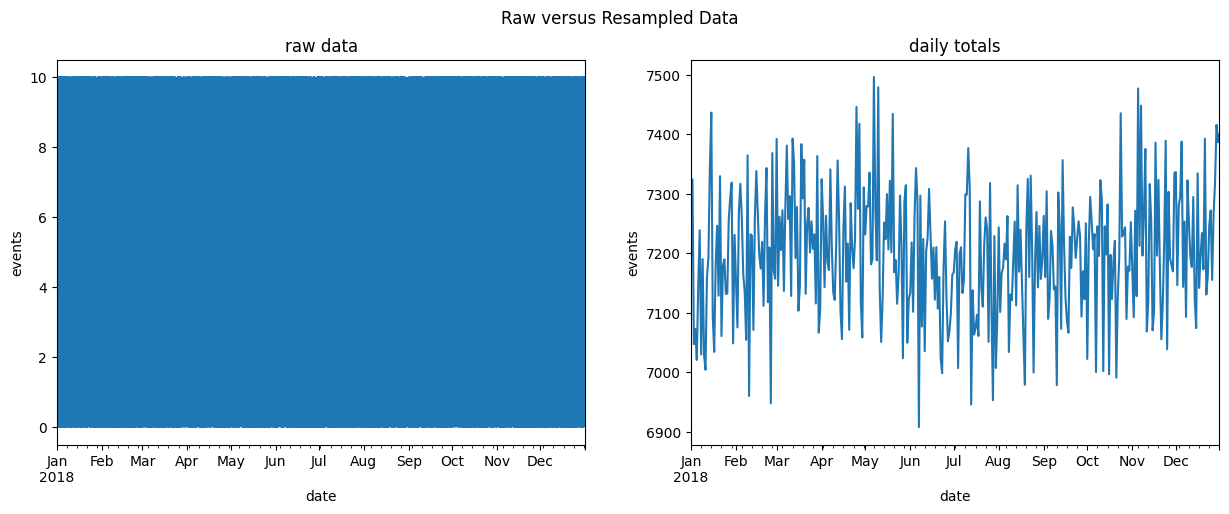

In [236]:
np.random.seed(0)
index = pd.date_range('2018-01-01', freq='T', periods=365*24*60)
raw = pd.DataFrame(
 np.random.uniform(0, 10, size=index.shape[0]), index=index
)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
raw.plot(legend=False, ax=axes[0], title='raw data')
raw.resample('1D').sum().plot(legend=False, ax=axes[1], title='daily totals')
for ax in axes:
 ax.set_xlabel('date')
 ax.set_ylabel('events')

plt.suptitle('Raw versus Resampled Data')
plt.show()

In [237]:
stock_data_per_minute.head()

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [238]:
stock_data_per_minute.resample('1D').agg({
 'open': 'first',
 'high': 'max',
 'low': 'min',
 'close': 'last',
 'volume': 'sum'
})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [ ]:
fb.resample('Q').mean()

In [240]:
fb.drop(columns='trading_volume').resample('Q').apply(
 lambda x: x.last('1D').values - x.first('1D').values
)

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\2934583360.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  fb.drop(columns='trading_volume').resample('Q').apply(
C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\2934583360.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  lambda x: x.last('1D').values - x.first('1D').values
C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\2934583360.py:2: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  lambda x: x.last('1D').values - x.first('1D').values
C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\2934583360.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  lambda x: x.last('1D').values - x.first('1D').v

date
2018-03-31    [[-22.53, -20.160000000000025, -23.41000000000...
2018-06-30    [[39.50999999999999, 38.399700000000024, 39.84...
2018-09-30    [[-25.039999999999992, -28.659999999999997, -2...
2018-12-31    [[-28.580000000000013, -31.24000000000001, -31...
Freq: QE-DEC, dtype: object

In [242]:
melted_stock_data = pd.read_csv('melted_stock_data.csv', index_col='date', parse_dates=True)
melted_stock_data.head()

,price
date,
2019-05-20 09:30:00,181.62
2019-05-20 09:31:00,182.61
2019-05-20 09:32:00,182.75
2019-05-20 09:33:00,182.95
2019-05-20 09:34:00,183.06


In [243]:
melted_stock_data.resample('1D').ohlc()['price']


,open,high,low,close
date,,,,
2019-05-20,181.62,184.18,181.62,182.72
2019-05-21,184.53,185.58,183.97,184.82
2019-05-22,184.81,186.56,184.01,185.32
2019-05-23,182.50,183.73,179.76,180.87
2019-05-24,182.33,183.52,181.04,181.06


In [244]:
fb.resample('6H').asfreq().head()

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\2962105639.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fb.resample('6H').asfreq().head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


In [ ]:
fb.resample('6H').pad().head()


In [246]:
fb.resample('6H').fillna('nearest').head()

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\3498320007.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fb.resample('6H').fillna('nearest').head()
C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\3498320007.py:1: FutureWarning: DatetimeIndexResampler.fillna is deprecated and will be removed in a future version. Use obj.ffill(), obj.bfill(), or obj.nearest() instead.
  fb.resample('6H').fillna('nearest').head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-02 18:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


In [247]:
fb.resample('6H').asfreq().assign(
 volume=lambda x: x.volume.fillna(0), # put 0 when market is closed
 close=lambda x: x.close.fillna(method='ffill'), # carry forward
 # take the closing price if these aren't available
 open=lambda x: np.where(x.open.isnull(), x.close, x.open),
 high=lambda x: np.where(x.high.isnull(), x.close, x.high),
 low=lambda x: np.where(x.low.isnull(), x.close, x.low)
).head()

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\2081602865.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fb.resample('6H').asfreq().assign(
C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\2081602865.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close=lambda x: x.close.fillna(method='ffill'), # carry forward


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 12:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 18:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


# Merging

We saw merging examples the querying_and_merging notebook. However, they all matched based on keys. With time series, it is possible that they are so granular that we
never have the same time for multiple entries. Let's work with some stock data at different granularities

In [249]:
import sqlite3
with sqlite3.connect('stocks.db') as connection:
 fb_prices = pd.read_sql(
 'SELECT * FROM fb_prices', connection,
 index_col='date', parse_dates=['date']
 )
 aapl_prices = pd.read_sql(
 'SELECT * FROM aapl_prices', connection,
 index_col='date', parse_dates=['date']
 )

In [250]:
fb_prices.index.second.unique()

Index([0], dtype='int32', name='date')

In [251]:
aapl_prices.index.second.unique()

Index([ 0, 52, 36, 34, 55, 35,  7, 12, 59, 17,  5, 20, 26, 23, 54, 49, 19, 53,
       11, 22, 13, 21, 10, 46, 42, 38, 33, 18, 16,  9, 56, 39,  2, 50, 31, 58,
       48, 24, 29,  6, 47, 51, 40,  3, 15, 14, 25,  4, 43,  8, 32, 27, 30, 45,
        1, 44, 57, 41, 37, 28],
      dtype='int32', name='date')

In [252]:
pd.merge_asof(
 fb_prices, aapl_prices,
 left_index=True, right_index=True, # datetimes are in the index
 # merge with nearest minute
 direction='nearest', tolerance=pd.Timedelta(30, unit='s')
).head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,NaN
2019-05-20 09:32:00,182.75,182.87
2019-05-20 09:33:00,182.95,182.50
2019-05-20 09:34:00,183.06,182.11


In [253]:

pd.merge_ordered(
 fb_prices.reset_index(), aapl_prices.reset_index(),
 fill_method='ffill'
).set_index('date').head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,183.52
2019-05-20 09:31:52,182.61,182.87
2019-05-20 09:32:00,182.75,182.87
2019-05-20 09:32:36,182.75,182.50


## 8.1.4 Data Analysis

Provide some comments here about the results of the procedures.

## 8.1.5 Supplementary Activity

Using the CSV files provided and what we have learned so far in this module complete the following exercises:

In [281]:
import pandas as pd
import numpy as np

In [311]:
earthquake = pd.read_csv('earthquakes.csv')
#this reads the earthquakes.csv
# using the read_csv() command
#from pandas library
earthquake

,mag,magType,time,place,tsunami,parsed_place
0,1.35,ml,1539475168010,"9km NE of Aguanga, CA",0,California
1,1.29,ml,1539475129610,"9km NE of Aguanga, CA",0,California
2,3.42,ml,1539475062610,"8km NE of Aguanga, CA",0,California
3,0.44,ml,1539474978070,"9km NE of Aguanga, CA",0,California
4,2.16,md,1539474716050,"10km NW of Avenal, CA",0,California
...,...,...,...,...,...,...
9327,0.62,md,1537230228060,"9km ENE of Mammoth Lakes, CA",0,California
9328,1.00,ml,1537230135130,"3km W of Julian, CA",0,California
9329,2.40,md,1537229908180,"35km NNE of Hatillo, Puerto Rico",0,Puerto Rico
9330,1.10,ml,1537229545350,"9km NE of Aguanga, CA",0,California


In [313]:
#1. With the earthquakes.csv file, select all the earthquakes in Japan
#with a magType of mb and a magnitude of 4.9 or greater.
# placing the dataframe with with the column call the column
# placing >, <, >=, <=  or == can be used to 
#filter out the column with specific entries using &
# to add another filter to be used
earthquake[(earthquake['mag'] >= 4.9) & (earthquake['magType'] == 'mb')]

,mag,magType,time,place,tsunami,parsed_place
227,5.20,mb,1539389603790,"15km WSW of Pisco, Peru",0,Peru
229,4.90,mb,1539389546300,"193km N of Qulansiyah, Yemen",0,Yemen
248,4.90,mb,1539382925190,"151km S of Severo-Kuril'sk, Russia",0,Russia
258,5.10,mb,1539380306940,"236km NNW of Kuril'sk, Russia",0,Russia
391,5.10,mb,1539337221080,Pacific-Antarctic Ridge,0,Pacific-Antarctic Ridge
...,...,...,...,...,...,...
9154,4.90,mb,1537268270010,Southwest Indian Ridge,0,Southwest Indian Ridge
9175,5.20,mb,1537262729590,"126km N of Dili, East Timor",1,East Timor
9176,5.20,mb,1537262656830,"90km S of Raoul Island, New Zealand",0,New Zealand
9213,5.10,mb,1537255481060,South of Tonga,0,Tonga


In [298]:
# 2. Create bins for each full number of magnitude
#(for example, the first bin is 0-1, the second is 1-2, and so on)
#with a magType of ml and count how many are in each bin.

bin_range = [x for x in range(int(earthquake['mag'].min()),int(earthquake['mag'].max())+ 2)]
bin_range
bin_text = [str(x) for x in bin_range]

 
earthquake['quake bins'] = pd.cut(earthquake['mag'],bin_range, bin_text)

earthquake.head()

,mag,magType,time,place,tsunami,parsed_place,quake bins
0,1.35,ml,1539475168010,"9km NE of Aguanga, CA",0,California,"(1, 2]"
1,1.29,ml,1539475129610,"9km NE of Aguanga, CA",0,California,"(1, 2]"
2,3.42,ml,1539475062610,"8km NE of Aguanga, CA",0,California,"(3, 4]"
3,0.44,ml,1539474978070,"9km NE of Aguanga, CA",0,California,"(0, 1]"
4,2.16,md,1539474716050,"10km NW of Avenal, CA",0,California,"(2, 3]"


In [299]:
earthquake.groupby(['quake bins'])['mag'].count()


C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\3740247262.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  earthquake.groupby(['quake bins'])['mag'].count()


quake bins
(-1, 0]     525
(0, 1]     2941
(1, 2]     3802
(2, 3]     1157
(3, 4]      233
(4, 5]      534
(5, 6]      117
(6, 7]        7
(7, 8]        1
Name: mag, dtype: int64

In [314]:
#3. Using the faang.csv file,
faang = pd.read_csv('faang.csv') # reading the csv file
# turning the date column entries to a
# datetime format using pd.to_datetime()
faang['date'] = pd.to_datetime(faang['date'])
# setting the index to the date colum
faang.set_index('date', inplace = True)
faang.head()

,ticker,open,high,low,close,volume
date,,,,,,
2018-01-02,FB,177.68,181.58,177.55,181.42,18151903
2018-01-03,FB,181.88,184.78,181.33,184.67,16886563
2018-01-04,FB,184.90,186.21,184.10,184.33,13880896
2018-01-05,FB,185.59,186.90,184.93,186.85,13574535
2018-01-08,FB,187.20,188.90,186.33,188.28,17994726


In [315]:
#group by the ticker and resample to monthly frequency.
#Make the following aggregations:
#Mean of the opening price
#Maximum of the high price 
#Minimum of the low price
#Mean of the closing price
#Sum of the volume traded
faang.groupby(['ticker']).resample('ME').agg({
    'open':'mean',
    'high':'max',
    'low': 'min',
    'close':'mean',
    'volume':'sum'
    })
#groupby is used to group each entry by what is inside the parenthesis
# the agg() is used to take a specific value 

open    high     low   close     volume
ticker date                                                 
AAPL   2018-01-31  170.71  176.68  161.57  170.70  659679440
       2018-02-28  164.56  177.91  147.99  164.92  927894473
       2018-03-31  172.42  180.75  162.47  171.88  713727447
       2018-04-30  167.33  176.25  158.22  167.29  666360147
       2018-05-31  182.64  187.93  162.79  183.21  620976206
       2018-06-30  186.61  192.02  178.71  186.51  527624365
       2018-07-31  188.07  193.76  181.37  188.18  393843881
       2018-08-31  210.46  227.10  195.10  211.48  700318837
       2018-09-30  220.61  227.89  213.64  220.36  678972040
       2018-10-31  219.49  231.66  204.50  219.14  789748068
       2018-11-30  190.83  220.64  169.53  190.25  961321947
       2018-12-31  164.54  184.15  145.96  163.56  898917007
AMZN   2018-01-31 1301.38 1472.58 1170.51 1309.01   96371290
       2018-02-28 1447.11 1528.70 1265.93 1442.36  137784020
       2018-03-31 1542.16 1617.54 1365.20 1540.37  130400151
       2018-04-30 1475.84 1638.10 1352.88 1468.22  129945743
       2018-05-31 1590.47 1635.00 1546.02 1594.90   71615299
       2018-06-30 1699.09 1763.10 1635.09 1698.82   85941510
       2018-07-31 1786.31 1880.05 1678.06 1784.65   97629820
       2018-08-31 1891.96 2025.57 1776.02 1897.85   96575676
       2018-09-30 1969.24 2050.50 1865.00 1966.08   94445693
       2018-10-31 1799.63 2033.19 1476.36 1782.06  183228552
       2018-11-30 1622.32 1784.00 1420.00 1625.48  139290208
       2018-12-31 1572.92 1778.34 1307.00 1559.44  154812304
FB     2018-01-31  184.36  190.66  175.80  184.96  495655736
       2018-02-28  180.72  195.32  167.18  180.27  516621991
       2018-03-31  173.45  186.10  149.02  173.49  996232472
       2018-04-30  164.16  177.10  150.51  163.81  751130388
       2018-05-31  181.91  192.72  170.23  182.93  401144183
       2018-06-30  194.97  203.55  186.43  195.27  387265765
       2018-07-31  199.33  218.62  166.56  199.97  652763259
       2018-08-31  177.60  188.30  170.27  177.49  549016789
       2018-09-30  164.23  173.89  158.87  164.38  500468912
       2018-10-31  154.87  165.88  139.03  154.19  622446235
       2018-11-30  141.76  154.13  126.85  141.64  518150415
       2018-12-31  137.53  147.19  123.02  137.16  558786249
GOOG   2018-01-31 1127.20 1186.89 1045.23 1130.77   28738485
       2018-02-28 1088.63 1174.00  992.56 1088.21   42384105
       2018-03-31 1096.11 1177.05  980.64 1091.49   45430049
       2018-04-30 1038.42 1094.16  990.37 1035.70   41773275
       2018-05-31 1064.02 1110.75 1006.29 1069.28   31849196
       2018-06-30 1136.40 1186.29 1096.01 1137.63   32103642
       2018-07-31 1183.46 1273.89 1093.80 1187.59   31953386
       2018-08-31 1226.16 1256.50 1188.24 1225.67   28820379
       2018-09-30 1176.88 1212.99 1146.91 1175.81   28863199
       2018-10-31 1116.08 1209.96  995.83 1110.94   48496167
       2018-11-30 1054.97 1095.57  996.02 1056.16   36735570
       2018-12-31 1042.62 1124.65  970.11 1037.42   40256461
NFLX   2018-01-31  231.27  286.81  195.42  232.91  238377533
       2018-02-28  270.87  297.36  236.11  271.44  184585819
       2018-03-31  312.71  333.98  275.90  312.23  263449491
       2018-04-30  309.13  338.82  271.22  307.47  262064417
       2018-05-31  329.78  356.10  305.73  331.54  142051114
       2018-06-30  384.56  423.21  352.82  384.13  244032001
       2018-07-31  380.97  419.77  328.00  381.52  305487432
       2018-08-31  345.41  376.81  310.93  346.26  213144082
       2018-09-30  363.33  383.20  335.83  362.64  170832156
       2018-10-31  340.03  386.80  271.21  335.45  363589920
       2018-11-30  290.64  332.05  250.00  290.34  257126498
       2018-12-31  266.31  298.72  231.23  265.30  234304628

In [316]:
# 4. Build a crosstab with the earthquake 
#data between the tsunami column and the magType column. 
#Rather than showing the frequency count, show the maximum
#magnitude that was observed for each combination. Put the magType along the columns.

cross_tabs = pd.crosstab(earthquake['tsunami'],earthquake['magType'],values = earthquake['mag'],aggfunc = ['max'])
cross_tabs


max                                               
magType   mb mb_lg   md   mh   ml ms_20   mw  mwb  mwr  mww
tsunami                                                    
0       5.60  3.50 4.11 1.10 4.20   NaN 3.83 5.80 4.80 6.00
1       6.10   NaN  NaN  NaN 5.10  5.70 4.41  NaN  NaN 7.50

In [317]:
#5. Calculate the rolling 60-day aggregations of OHLC data by ticker for
#the FAANG data. Use the same aggregations as exercise no. 3.
roll = faang.groupby(['ticker']).rolling('60D').agg({
    'open':'mean',
    'high':'max',
    'low': 'min',
    'close':'mean',
    'volume':'sum'
    
})
roll

open   high    low  close       volume
ticker date                                               
AAPL   2018-01-02 166.93 169.03 166.04 168.99  25555934.00
       2018-01-03 168.09 171.23 166.04 168.97  55073833.00
       2018-01-04 168.48 171.23 166.04 169.23  77508430.00
       2018-01-05 168.90 172.04 166.04 169.84 101168448.00
       2018-01-08 169.32 172.27 166.04 170.08 121736214.00
...                  ...    ...    ...    ...          ...
NFLX   2018-12-24 283.51 332.05 233.68 281.93 525657894.00
       2018-12-26 281.84 332.05 231.23 280.78 520444588.00
       2018-12-27 281.07 332.05 231.23 280.16 532679805.00
       2018-12-28 279.92 332.05 231.23 279.46 521968250.00
       2018-12-31 278.43 332.05 231.23 277.45 476309676.00

[1255 rows x 5 columns]

In [318]:
#6. Create a pivot table of the FAANG data that compares the stocks.
#Put the ticker in the rows and show the averages of the OHLC and volume traded data.
pivot_table = faang.pivot_table(index = faang['ticker'],
values = faang[['open','high','low','close','volume']], aggfunc = ['mean'])
pivot_table


mean                                    
         close    high     low    open      volume
ticker                                            
AAPL    186.99  188.91  185.14  187.04 34021449.63
AMZN   1641.73 1662.84 1619.84 1644.07  5649562.81
FB      171.51  173.62  169.30  171.45 27687977.67
GOOG   1113.23 1125.78 1101.00 1113.55  1742645.08
NFLX    319.29  325.22  313.19  319.62 11470299.17

In [319]:
#7. Calculate the Z-scores for each numeric column
# of Netflix's data (ticker is NFLX) using apply().
NTFLX = faang.query('ticker == "NFLX"')
columns = ['open','high','low','close','volume']

NTFLX[columns] = NTFLX[columns].apply(lambda x: (x - x.mean())/x.std())

NTFLX

C:\Users\Arnel Bulambao\AppData\Local\Temp\ipykernel_9592\2097626456.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NTFLX[columns] = NTFLX[columns].apply(lambda x: (x - x.mean())/x.std())


,ticker,open,high,low,close,volume
date,,,,,,
2018-01-02,NFLX,-2.50,-2.52,-2.41,-2.42,-0.09
2018-01-03,NFLX,-2.38,-2.42,-2.29,-2.34,-0.51
2018-01-04,NFLX,-2.30,-2.41,-2.23,-2.32,-0.96
2018-01-05,NFLX,-2.28,-2.35,-2.20,-2.23,-0.78
2018-01-08,NFLX,-2.22,-2.30,-2.14,-2.19,-1.04
...,...,...,...,...,...,...
2018-12-24,NFLX,-1.57,-1.52,-1.63,-1.75,-0.34
2018-12-26,NFLX,-1.74,-1.44,-1.68,-1.34,0.52
2018-12-27,NFLX,-1.41,-1.42,-1.50,-1.30,0.13



8. Add event descriptions:

   • Create a dataframe with the following three columns: ticker, date, and event. The columns should have the following values:
   
           ▪ ticker: 'FB'
   
           ▪ date: ['2018-07-25', '2018-03-19', '2018-03-20']
   
           ▪ event: ['Disappointing user growth announced after close.', 'Cambridge Analytica story', 'FTC investigation']
   
   • Set the index to ['date', 'ticker']
   
   • Merge this data with the FAANG data using an outer join


In [326]:
faang_n = {
    'ticker':'FB',
    'date':['2018-07-25', '2018-03-19', '2018-03-20'],
    'event':['Disappointing user growth announced after close.', 'Cambridge Analytica story', 'FTC investigation']
}

# Now we successsfully created a new dataframe
faang_n = pd.DataFrame(faang_n)
# since the are no datatypes after creating dataframe we must set it first before turning it into index

faang_n['date'] = pd.to_datetime(faang_n['date'])
# we set index of date and ticker into the new faang
faang_n.set_index(['date','ticker'], inplace = True)

In [321]:
merge_df = faang.merge(faang_n, on = ['date','ticker'], how = 'outer')
merge_df = merge_df.sort_index()

In [322]:
merge_df

,ticker,open,high,low,close,volume,event
date,,,,,,,
2018-01-02,AAPL,166.93,169.03,166.04,168.99,25555934,NaN
2018-01-02,AMZN,1172.00,1190.00,1170.51,1189.01,2694494,NaN
2018-01-02,FB,177.68,181.58,177.55,181.42,18151903,NaN
2018-01-02,GOOG,1048.34,1066.94,1045.23,1065.00,1237564,NaN
2018-01-02,NFLX,196.10,201.65,195.42,201.07,10966889,NaN
...,...,...,...,...,...,...,...
2018-12-31,AAPL,157.85,158.68,155.81,157.07,35003466,NaN
2018-12-31,AMZN,1510.80,1520.76,1487.00,1501.97,6954507,NaN
2018-12-31,FB,134.45,134.64,129.95,131.09,24625308,NaN


   
9. Use the transform() method on the FAANG data to represent all the values in terms of the first date in the data. To do so, divide all the values for each ticker by the values
for the first date in the data for that ticker. This is referred to as an index, and the data for the first date is the base (https://ec.europa.eu/eurostat/statistics-explained/
index.php/ Beginners:Statisticalconcept-Indexandbaseyear). When data is in this format, we can easily see growth over time. Hint: transform() can take a function name.

In [323]:
m_copy = merge_df.copy()


In [325]:
columns = ['open','high','low','close','volume'] 
# this are the columns that need to be outputted
#using groupby to group the datas by ticker
#and using the columns made as the coulmns of datas that are needed to be taken
m_copy.groupby(['ticker'])[columns].transform(lambda x: x/x.iloc[0])

,open,high,low,close,volume
date,,,,,
2018-01-02,1.00,1.00,1.00,1.00,1.00
2018-01-02,1.00,1.00,1.00,1.00,1.00
2018-01-02,1.00,1.00,1.00,1.00,1.00
2018-01-02,1.00,1.00,1.00,1.00,1.00
2018-01-02,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...
2018-12-31,0.95,0.94,0.94,0.93,1.37
2018-12-31,1.29,1.28,1.27,1.26,2.58
2018-12-31,0.76,0.74,0.73,0.72,1.36
